In [14]:
import numpy as np
import cv2
import os
import glob as glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
def createImagesDataset(img_folder, resize_dim=(64, 64)):
    img_data_array = []
    class_name = []
    for dirl in os.listdir(img_folder):
        for file in tqdm(os.listdir(os.path.join(img_folder,dirl))):
            if any([file.endswith(x) for x in ['.jpeg', '.jpg']]):
                image_path = os.path.join(img_folder, dirl, file)
                image = cv2.imread(image_path)
                image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(image_bw, resize_dim)
                img_data_array.append(img)
                class_name.append(dirl)
    return img_data_array,class_name

data_folder_path = "/content/drive/MyDrive/Drowsiness-Detection-Analysis/train"

train_image_array, train_class_names = createImagesDataset(data_folder_path, (64, 64))


100%|██████████| 617/617 [00:10<00:00, 59.69it/s] 


In [4]:
test_data_folder_path = "/content/drive/MyDrive/Drowsiness-Detection-Analysis/test"

test_image_array, test_class_names = createImagesDataset(test_data_folder_path, (64, 64))

100%|██████████| 109/109 [00:03<00:00, 31.22it/s]


In [16]:
plot_images = False
#neural network takes in a numpy array as the features and labels so convert from list to array and change shape
X = ((np.array(train_image_array).reshape(-1, 64, 64))/255.0).astype("float32")
y = np.array(train_class_names)

if plot_images:
    #show first feature image X
    first_feature = X[0]
    plt.imshow(first_feature, cmap = 'gray')
    plt.axis('off')
    print('The image shape is {}'.format(first_feature.shape))

#neural network takes in a numpy array as the features and labels so convert from list to array and change shape
encoder = OneHotEncoder()

X_reshaped = np.array(train_image_array).reshape(-1, 64, 64, 1).astype("float32")
y_reshaped = encoder.fit_transform(np.array(train_class_names).reshape(-1, 1))

#separate training and test data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.05, random_state=42)
print('the shape of training features is {}'.format(X_train.shape))
print('the shape of training labels is {}'.format(y_train.shape))
print('the shape of test features is {}'.format(X_test.shape))
print('the shape of test labels is {}'.format(y_test.shape))

the shape of training features is (2343, 64, 64, 1)
the shape of training labels is (2343, 4)
the shape of test features is (124, 64, 64, 1)
the shape of test labels is (124, 4)


In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x


def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x


def ResidualNetworkFunction(shape = (32, 32, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [1, 2, 2, 2, 1]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(len(block_layers)):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model


resnetModel = ResidualNetworkFunction(shape=(64, 64, 1), classes=4)

resnetModel.summary()


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 35, 35, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 35, 35, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [19]:
resnetModel.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0007, 
                                                        rho=0.75, 
                                                        momentum=0.75), 
                metrics=['accuracy'])

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, 
                                                    patience=50, 
                                                    min_lr=0.001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0)

callbacks = [lr_reduction, early_stopping]

history = resnetModel.fit(X_train, y_train.toarray(), 
                            batch_size=512, 
                            validation_split=0.05, 
                            shuffle=True, 
                            epochs=1000, 
                            initial_epoch=0, callbacks=callbacks)


Epoch 1/1000
5/5 [==============================] - 16s 478ms/step - loss: 3.2126 - accuracy: 0.3892 - val_loss: 3710761.0000 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 2/1000
5/5 [==============================] - 1s 148ms/step - loss: 1.1566 - accuracy: 0.5187 - val_loss: 7712177.0000 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 3/1000
5/5 [==============================] - 1s 147ms/step - loss: 0.6928 - accuracy: 0.5537 - val_loss: 5562289.0000 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 4/1000
5/5 [==============================] - 1s 147ms/step - loss: 0.6589 - accuracy: 0.5600 - val_loss: 558110.3125 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 5/1000
5/5 [==============================] - 1s 148ms/step - loss: 0.6437 - accuracy: 0.5879 - val_loss: 213520.8438 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 6/1000
5/5 [==============================] - 1s 148ms/step - loss: 0.6650 - accuracy: 0.6148 - val_loss: 352214.7500 - val_accuracy: 0.2203 - lr: 7.0000e-04
Epoch 7/1000

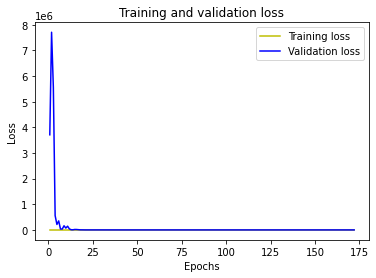

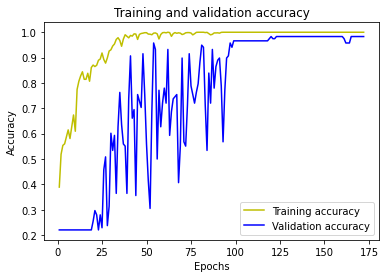

In [21]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Performance Summary of Sequential Neural Network on test data:
              precision    recall  f1-score   support

      Closed       0.97      1.00      0.99        33
        Open       1.00      0.92      0.96        26
     no_yawn       0.94      0.97      0.95        32
        yawn       0.94      0.94      0.94        33

    accuracy                           0.96       124
   macro avg       0.96      0.96      0.96       124
weighted avg       0.96      0.96      0.96       124

The Confusion Matrix is : 
AxesSubplot(0.125,0.125;0.62x0.755)


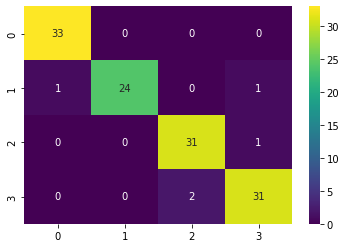

In [25]:
#use predict_classes() to find the class with the highest probability
import sklearn
import seaborn as sns

y_pred = resnetModel.predict(X_test)
y_pred_readable = encoder.inverse_transform(y_pred)
y_test_readable = encoder.inverse_transform(y_test)

print("Performance Summary of Sequential Neural Network on test data:")
#show classification report
print(sklearn.metrics.classification_report(y_test_readable, y_pred_readable))
#show confusion matrix
print("The Confusion Matrix is : ")
print(sns.heatmap(sklearn.metrics.confusion_matrix(y_test_readable, y_pred_readable), cmap='viridis', 
                  annot=True, xticklabels=True, yticklabels=True))



In [26]:
resnetModel.save("cnnCat3.h5")

In [74]:

def ResNetModelInference(model_path, image_path, resizeDim=(64, 64), 
                         dataType="float32", plotImage=False) :
    import warnings
    warnings.filterwarnings("ignore")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    testImage = cv2.resize(cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2GRAY), resizeDim)
    
    if plotImage :
        plt.imshow(testImage)

    reshapedImage = testImage.reshape(-1, resizeDim[0], resizeDim[1], 1).astype(dataType)
    predictionResNet = np.argmax(model.predict(reshapedImage), axis=1)
    if predictionResNet[0] == 0 :
        print("Closed Eyes....")
        return 
    elif predictionResNet[0] == 1 :
        print("Open Eyes....")
        return 
    elif predictionResNet[0] == 2 :
        print("No Yawning Present....")
        return
    else :
        print("Yawning Present....")
        return

In [77]:
MODEL = "/content/cnnCat3.h5"

IMAGE_1 = "/content/_14.jpg"
IMAGE_2 = "/content/2607.jpg"
IMAGE_3 = "/content/95.jpg"
IMAGE_4 = "/content/_46.jpg"


Closed Eyes....


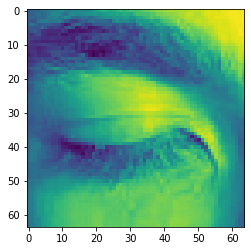

In [78]:
ResNetModelInference(MODEL, IMAGE_1, plotImage=True)

No Yawning Present....


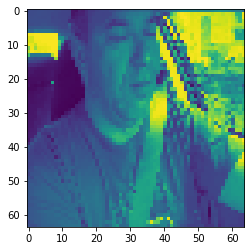

In [79]:
ResNetModelInference(MODEL, IMAGE_2, plotImage=True)

Yawning Present....


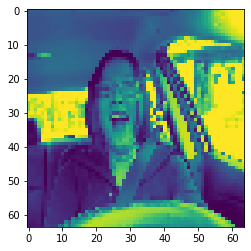

In [80]:
ResNetModelInference(MODEL, IMAGE_3, plotImage=True)

Open Eyes....


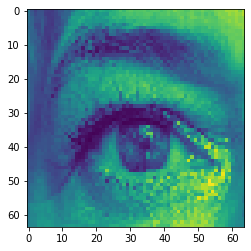

In [81]:
ResNetModelInference(MODEL, IMAGE_4, plotImage=True)